# Bayesian Demand Estimation for San Francisco Bike Share 

### Samuel Sharpe & Nihaar Shah

 Bike share systems present multiple problems that are uniquely suited to bayesian methods. Bike share systems must have a good understanding of customers in order to properly set up new bike stations, decide station bike capacities, and implement strategies to replenish stations when empty. While there are many elements of customer tendencies that can inform these decisions, we decided to focus on the largest driver, bike demand. Bayesian methods provide more information than maximum likelihood estimates of demand for bike share decision making. For example, if we want to rebalance bikes for a certain station, a bayesian demand estimate can tell us how likely it is that a station will run out of bikes in the next 3 hours (with a simple assumption of no supply). We approach demand estimation with various types of bayesian regression.

In [1]:
import pickle
import sys
sys.path.insert(0,'../src/')

import baseline
import zipreg 
import zipgate_reg
import negbin
import negbin_reg
from inference import *
from criticism import *
from preprocess_bikeshare import *
from gmm_model_main import *
import matplotlib.pyplot as plt
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
# Set to true for fast run of notebook
QUICK_RUN = True

if QUICK_RUN:
    iters = 2000
    n_samples = 1000
    model_param_suffix = '_quick'
    with open('../data/final_train_small.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test_small.pickle', 'rb') as f:
        test=pickle.load(f)
else:
    iters = 9000
    n_samples = 1000
    model_param_suffix =''
    with open('../data/final_train.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test.pickle', 'rb') as f:
        test=pickle.load(f).sample(50000, random_state = 0)
    
    
stations = pd.read_csv('../data/stations.csv')


## Data

Our [data](https://www.kaggle.com/benhamner/sf-bay-area-bike-share) ranges over 2 years and includes approximately 670,000 trips taken over that time period. First, a look at some of the basic trends shows us a wide variety of demand at each station and cyclic demand patterns throughout the day on the week and weekend. Included along with this data is information about the stations themselves (number of bike racks) as well as daily weather data. We aggregated this data into 3 hour chunks to make
inference a little quicker and realizing we didn't need the granularity that 1 hour chunks provided. 

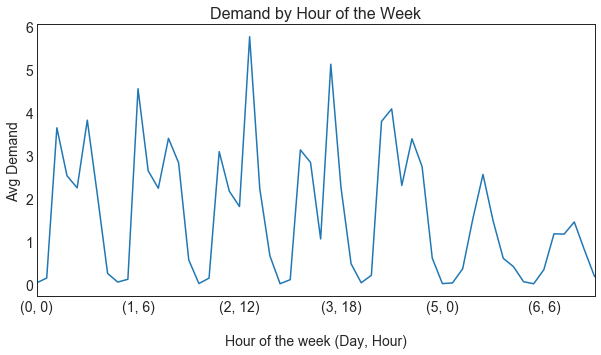

In [3]:
train.groupby(['weekday','hour'])['demand'].mean().plot.line(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Demand by Hour of the Week', fontsize=16)
plt.show()

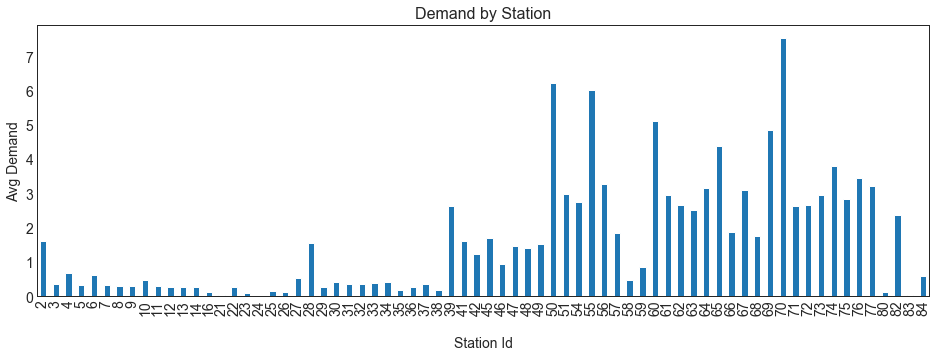

In [4]:
train.groupby(['start_station_id'])['demand'].mean().plot.bar(figsize = (16,5))
plt.xlabel('\nStation Id')
plt.ylabel('Avg Demand')
plt.title('Demand by Station', fontsize=16)
plt.show()

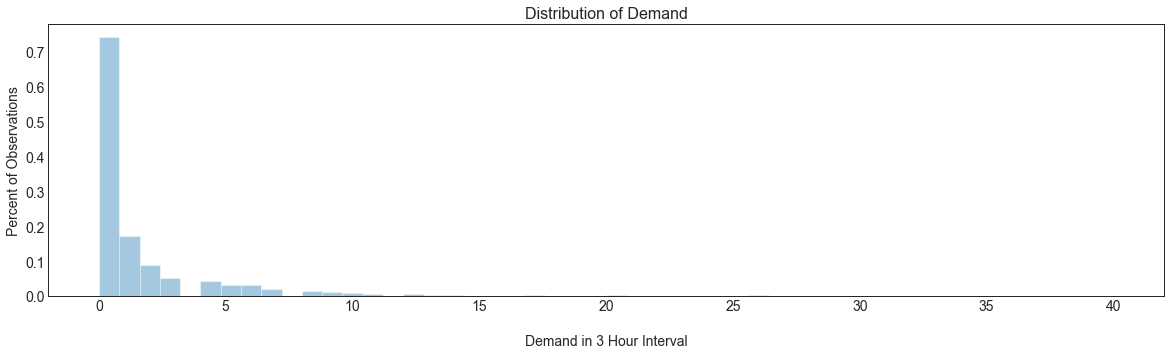

count    2800.00
mean        1.63
std         3.39
min         0.00
50%         0.00
70%         1.00
80%         2.00
90%         5.00
95%         8.00
99%        16.00
max        40.00
Name: demand, dtype: float64


In [5]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))
plt.figure(figsize=(20,5))
sns.distplot(train['demand'],norm_hist=True, kde = False)
plt.xlabel('\nDemand in 3 Hour Interval')
plt.ylabel('Percent of Observations')
plt.title('Distribution of Demand', fontsize=16)
plt.show()
print(train['demand'].describe(percentiles=[.5,.7,.8,.9,.95,.99]).round(2))

## Model 1: Model Formulation (Poisson)

We thought a regression would be a sound way to model the data rather than timeseries based methods. We are trying to 
model demand uncertainty based off various factors. A regression can capture a large portion of this information given our patterns are largely cyclical. We decided to first apply Poisson regression. Though the distribution above suggests that Poisson may not be the best fit, it is a good starting point for modeling count data. 

We started with some simple assumptions that our rate of arrivals depend on two latent arrival components for stations and time:

$$\text{station s} = \mu_s$$
$$\text{time (weekday w, hour h)} = \mu_{w,h} $$
$$w \in \{\text{weekday, weekend}\}, h \in \{0,3,6,9,12,15,18,21\}$$

Our priors on our latent components are simply:

$$\mu_s, \mu_{w,h} \sim \mathcal{N}(0,1)$$

We assume for this model that demand observation $i$ at a station $s$ and time $w,h$ follow a Poisson distribution:

$$d_{i,s,w,h} \sim Pois(\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Let $M_{s,w,h}$ be the number of observations at a station $s$ and time $w,h$.We can write the joint probability for this model as

$$p(d,\mu_s,\mu_{w,h}) = \prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}$$

## Model 1: Inference

In [6]:
b_data, b_features = baseline.feature_generation(train)
b_data_test, _ = baseline.feature_generation(test)
b = baseline.PoissReg(b_features, b_data)

In [7]:
#Perform SVI
svi_baseline, elbo_loss = run_svi(b.model, b.guide,
                                 iters=iters,
                                 data=b_data['data'],
                                 demand=b_data['demand'],
                                 filename=f'../models/svi_baseline_params{model_param_suffix}.pkl')

svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],svi=svi_baseline)


../src/baseline.py:86: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 18160.544921875
Elbo loss: 4880.921875


## Model 1: Criticism

In [8]:
print(f"WAIC: {float(svi_posterior_baseline.information_criterion()['waic'].detach().numpy())}")


WAIC: 9978.951171875


In [9]:
post_samples_base = ppd_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data_test,
    ['obs'],
    num_samples=n_samples).squeeze()

Below is a plot of the hallucinated data i.e. the Posterior Predictive samples. While it mirrors the cyclical trend of the original dataset there are some shortcomings in its ability to model extreme values.

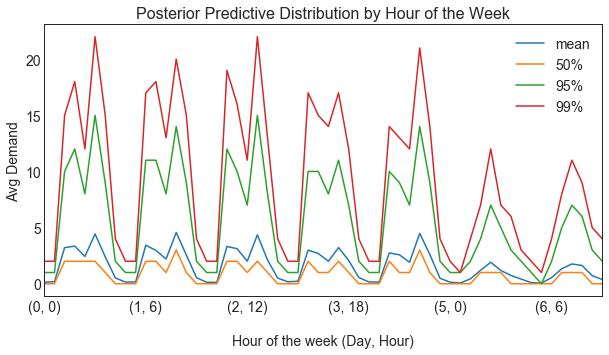

In [10]:
post_combined = align_regressors_ppd(test, post_samples_base)
post_combined.groupby(['weekday','hour'])['value'].describe(percentiles = [.5,.95,.99])[['mean','50%','95%','99%']].plot(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Posterior Predictive Distribution by Hour of the Week', fontsize=16)
plt.show()

We can see with some simple checks of the posterior predictive distribution (PPD) that a Poisson distribution may not be the best assumption. We underestimate the number of demand observations with no bikes taken off the rack. Poisson regression also underestimates the overal maximum demand in any 3 hour period. 

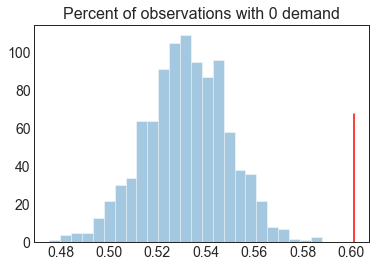

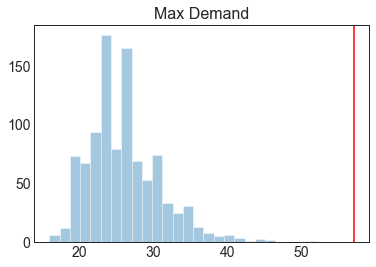

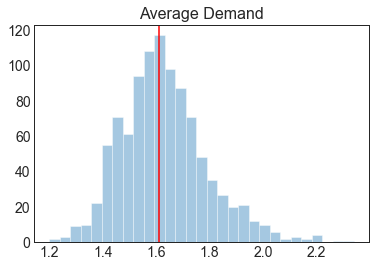

In [11]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=max_, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_base, stat=mean, title = 'Average Demand')


## Reconsidering Distribution Assumptions

We can model the average rate well with a Poisson assumption, but the  $Var[D]$ is restricted to be equal to $E[D]$. The demand distribution is overdispersed as seen by the average and variance below. Since we underestimate the percentage of time periods with no demand, a Zero Inflated Poisson (ZIP) may be a better assumption. ZIP will allow the distribution to vary a bit more and keep some mass on 0.

In [12]:
#Overdispersed 
print(f'Demand mean: {train["demand"].mean().round(3)}')
print(f'Demand var: {train["demand"].var().round(3)}')
      

Demand mean: 1.63
Demand var: 11.483


In [13]:
# Distribution of overdispersion (Var(x)/E[x]) by station and time
m_v = train.groupby(['start_station_id','weekday','hour'])['demand'].agg(['mean','var'])
(m_v['var']/m_v['mean']).describe()


count    314.000000
mean       1.238978
std        1.246610
min        0.000000
25%        0.333333
50%        1.000000
75%        1.990000
max        9.000000
dtype: float64

## Model 2: Model Formulation (Zero Inflated Poisson)

Now we assume that demand follows a Zero Inflated Poisson distribution (ZIP) which can be thought of as a mixture of a poisson and bernoulli. 

$$p(k) = (1-\rho)\frac{\lambda^k e^{-\lambda}}{k!} + \rho {1}_{k=0}$$



We keep the same priors on our station and time latent factors. 

We assume that we have one global $\rho$ where
$$\rho \sim Beta(\alpha, \beta)$$ 

and we impose another level of priors encoding an initial belief that $\rho<.5$:
$$\alpha \sim Gamma(2,2)$$
$$\beta \sim Gamma(3,2)$$

Again, our assumtion on demand:

$$d_{i,s,w,h} \sim ZIP(\rho,\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Our new joint probability for this model is:
$$p(\rho,\alpha, \beta) = \frac{2^2}{\Gamma(2)}\alpha e^{-2\alpha}\frac{2^3}{\Gamma(3)}\beta e^{-2\beta}\frac{1}{B(\alpha, \beta)}\rho^{\alpha-1}(1-\rho)^{\beta-1}$$

$$p(d,\mu_s,\mu_{w,h},\rho) = p(\rho,\alpha, \beta) \prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \left[(1-\rho)\frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}+ \rho1_{d_{i, s,w,h}=0}\right]$$

## Model 2: Inference

In [14]:
z_data, z_features = zipreg.feature_generation(train)
z_data_test,_ = zipreg.feature_generation(test)
z = zipreg.ZIPoissReg(z_features, z_data)


In [15]:
# Perform SVI
svi_zip, elbo_loss = run_svi(z.model, z.guide,
                                 iters=iters,
                                 data=z_data['data'],
                                 demand=z_data['demand'],
                                 filename=f'../models/svi_zip_params{model_param_suffix}.pkl')

svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],svi=svi_zip)

../src/zipreg.py:114: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_alpha_loc = pyro.param('gate_alpha_loc', torch.tensor(3.),
../src/zipreg.py:116: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_beta_loc = pyro.param('gate_beta_loc', torch.tensor(3.),
../src/zipreg.py:148: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be th

## Model 2: Criticism 

In [16]:
print(f"WAIC: {float(svi_posterior_zip.information_criterion()['waic'].detach().numpy())}")

WAIC: 9091.28515625


In [17]:
post_samples_zip = ppd_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data_test,
    ['obs'],
    num_samples=n_samples).squeeze()

In [18]:
post_combined_zip = align_regressors_ppd(test, post_samples_zip)


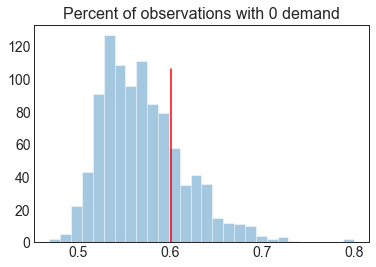

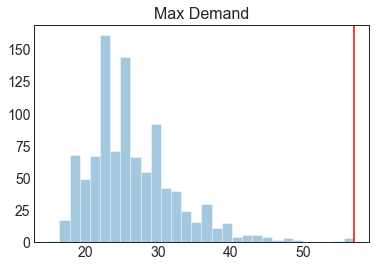

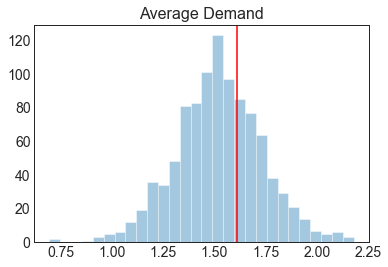

In [19]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=max_, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_zip, stat=mean, title = 'Average Demand')

Our ppd checks show an improvement in modeling periods with no demand, however, the ppd check on the max of the distribution did not come close to reaching the actual test data, we posit that our model needs more flexibility with its variance $Var[D]$.

## Model 3: Model Formulation (Negative Binomial)

$Y \sim NB(r,p)$ which has the probability density function:
$$ p(Y=d |(r,p)) = {(d+r-1) \choose (d)} (1-p)^r p^d  =\frac{\Gamma(k+r)}{k!\Gamma(r)}(1-p)^r p^d $$


$$r \sim Gamma(1,1) \therefore Pr(r) = \frac{1}{\Gamma(1)} exp(-r)$$

We place the same normal priors on $\mu$:
$$\mu_{h,d}, \mu_{s}\sim N(0,1)$$

Our joint model is then:


$$Pr(d,r,\mu_s,\mu_{w,h}) =  Pr(r) \prod_{s \in S} Pr(\mu_s) \prod_{w \in W}\prod_{h \in H} Pr(\mu_{w,h}) \prod_{i=1}^{M_{s,w,h}} Pr(d_{i, s,w,h}|(r,\mu_s,\mu_{w,h}))$$

Let $p_{i, s,w,h} = \sigma(\mu_s+\mu_{w,h})$

$$Pr(d,r,\mu_s,\mu_{w,h}) = \frac{e^{-r}}{\Gamma(1)}\prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{\Gamma(d_{i, s,w,h}+r)}{d_{i, s,w,h}!\Gamma(r)}(1-p_{i, s,w,h})^r p_{i, s,w,h}^{d_{i, s,w,h}}$$

## Model 3: Inference

In [20]:
nb_data, nb_features = negbin.feature_generation(train)
nb_data_test, _ = negbin.feature_generation(test)
nb = negbin.NegBinReg(nb_features, nb_data)


In [21]:
# Perform SVI
svi_negbin, elbo_loss = run_svi(nb.model, nb.guide,
                                 iters=iters,
                                 data=nb_data['data'],
                                 demand=nb_data['demand'],
                                 filename=f'../models/svi_negbin_params{model_param_suffix}.pkl')

svi_posterior_negbin = get_svi_posterior(nb_data['data'], nb_data['demand'],
                                          svi=svi_negbin)

../src/negbin.py:112: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  total_count_loc = pyro.param('total_count_loc', torch.tensor(5.),
../src/negbin.py:145: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  total_count_loc, torch.tensor(0.25)))
../src/negbin.py:90: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the tr

## Model 3: Criticism 

In [22]:
print(f"WAIC: {float(svi_posterior_negbin.information_criterion()['waic'].detach().numpy())}")

WAIC: 7012.08642578125


In [23]:
post_samples_negbin= ppd_samples(
    nb.wrapped_model,
    svi_posterior_negbin,
    nb_data_test,
    ['obs'],
    num_samples=1000).squeeze()

In [24]:
# Align regressors with ppd
post_combined_negbin = align_regressors_ppd(test, post_samples_negbin)

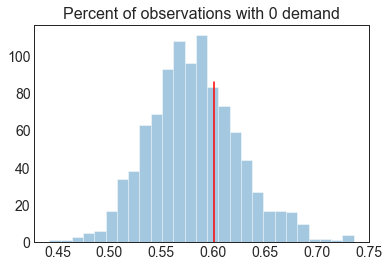

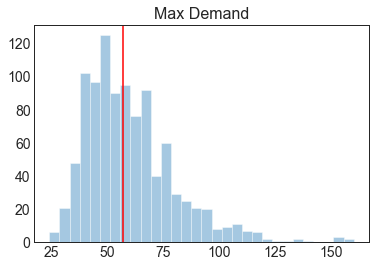

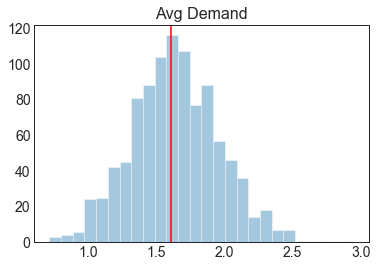

In [25]:
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=max_, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=mean, title = 'Avg Demand')

A negative binomial assumption results in better ppd checks on especially the maximum. We also see a much larger variance in our posterior predictive distribution on average and max demand. 

## Comparing Models at Station Level

We looked at all 3 models and how various test statistics perform by station. We looked at the distributions of differences between the E[ppd test statistic] and actual test statistic for all stations. This gives us an idea if some models are better at modeling certain test statistics at the station level. Higher values imply the PPD is further from the actual test data with respect to that statistic. While the negative binomial model performs well at the global level, it breaks down somewhat at the station level when it comes to modeling the max demand by station.   

In [26]:
from functools import partial
p80 = partial(percentile, q = 80)
p90 = partial(percentile, q = 90)
funs = [mean, perc_0, var, max_, p80, p90]
labels =['mean','perc_0','var','max','p80','p90']
models = [post_combined, post_combined_zip, post_combined_negbin]
model_names = ['Poisson','ZIP','Negative Binomial']

compare_dict = {}
for i in range(len(funs)):
    compare_dict[labels[i]] = []
    for m in models:
        compare_dict[labels[i]].append(stat_by_station(test, m, stat = funs[i])['diff'])

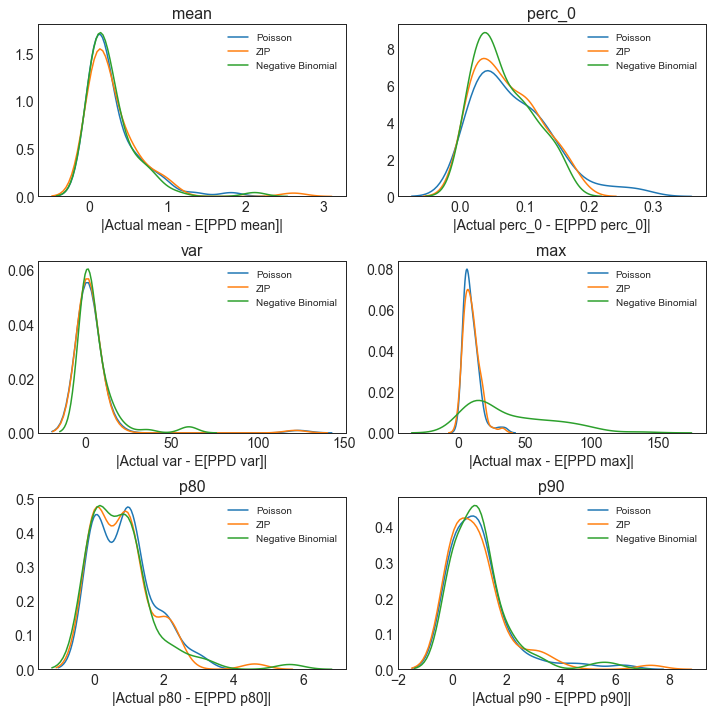

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for l in range(len(labels)):
    ax = axs[int(l/2), l%2]
    for i in range(3):
        sns.distplot(compare_dict[labels[l]][i], label = model_names[i], hist = False,ax = ax )
        ax.title.set_text(labels[l])
        ax.set_xlabel(f'|Actual {labels[l]} - E[PPD {labels[l]}]|')
        ax.legend(prop={'size': 10})

fig.tight_layout() 
plt.show()

# Considerations & Future Work

Our ZIP and negative binomial models leave room for future work. In our modeling exploration we experimented with varying $\rho$ (in ZIP) and $r$ (in NB) by station and time of day to control for possible fluctuations in variance by these categories. Implementing regression which has more than just one global parameter for $\rho$ or $r$ may improve our station level performance. Stations may also behave differently by hour of the day for stations in residential and urban areas. We noticed that increasingly complex models (latent variables for every hour at each station) did not improve WAIC due to the large increase in parameters. To prevent introducing many more parameters, we may also benefit from introducing latent groups of stations and times of day which behave similarly, thus reducing our parameters while not losing predictive value. We investigated this by grouping 16 time based latent variables for station-70 into categories via a GMM and found coherent groupings i.e. variables associated with low demand hours grouped together etc. 

seed = 80, initial_loss = 3755.554931640625

...................................................................................................
...................................................................................................
weights = [0.18732145 0.17999001 0.07312745 0.31020975 0.24935128]
locs = [0.8255452  7.7739367  5.593525   0.82599086 3.405046  ]
scale = 0.5757808685302734


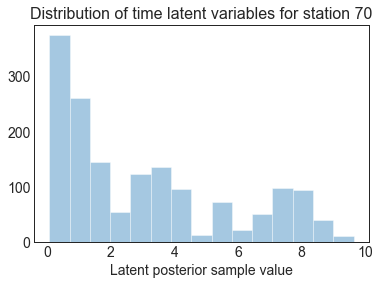

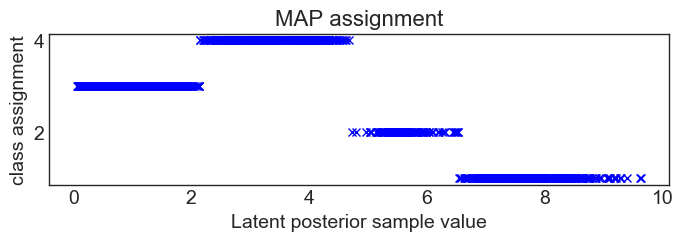

In [28]:
with open('../data/example_posteriors.pkl', 'rb') as f:
    ex_post = pickle.load(f).exp()

plt.title('Distribution of time latent variables for station 70')
plt.xlabel('Latent posterior sample value')
sns.distplot(ex_post,kde=False)
assignment = run_GMM(ex_post,5)

In [29]:
sites_list = create_sites('station_70',b_features)
station_categories = assign_station_categories(assignment)
dic = create_dict(sites_list,station_categories)
tabulate_results(dic)

Category		Latent Variable
--------		--------------
0		hour_21_weekend, hour_0_weekday, hour_0_weekend, hour_3_weekday, hour_6_weekday, hour_18_weekday, hour_18_weekend, hour_21_weekday, hour_21_weekend
1		hour_3_weekend, hour_12_weekend, hour_15_weekend
2		hour_6_weekend
3		hour_9_weekday, hour_9_weekend, hour_12_weekday, hour_15_weekday
